In [1]:
# Install Folium
#pip install folium
# Install Dtale data frame visualization package
#!pip install --upgrade dtale


In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import os
import folium
from folium.plugins import HeatMap

import dtale # data Frame visualization

import datetime   # handle date times
import re         # regular expression package

In [3]:
# Check if data has been pickled and if so load pickle
# else pickle only the attributes we are interested in, and compress
# pickle is much faster/smaller than csv
if os.path.exists('data/txDF.pkl') :
    txDF=pd.read_pickle('data/txDF.pkl',compression='gzip')
else:
    df = pd.read_csv('data/US_Accidents_Dec19.csv',encoding='utf-8')
    df.to_pickle("data/DF.pkl",compression='gzip')
    columns_of_interest=[
        'ID','Severity','Start_Time','End_Time','Start_Lat', 'Start_Lng', 'City', 
        'County', 'State','Zipcode', 'Country','Visibility(mi)', 
        'Weather_Condition','Precipitation(in)','Sunrise_Sunset','Civil_Twilight'
    ]
    condition=df['State'] =='TX'
    txDF=df[condition][columns_of_interest] 
    txDF.to_pickle("data/txDF.pkl",compression='gzip')

# Date Attributes

Separate the *start_time* attribute into it several date components


In [4]:
# code fron fast ai
# Date Feature Engineering
# will split data colum in to corresponding 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear'
def add_datepart(df, fldname, drop=True,time=False):
    fld = df[fldname]
    attributes = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    if time: attributes = attributes + ['Hour', 'Minute', 'Second']
    #, 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in attributes:
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)


In [5]:
add_datepart(txDF,'Start_Time',False,True )
txDF.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'City', 'County', 'State', 'Zipcode', 'Country', 'Visibility(mi)',
       'Weather_Condition', 'Precipitation(in)', 'Sunrise_Sunset',
       'Civil_Twilight', 'Start_TimeYear', 'Start_TimeMonth', 'Start_TimeWeek',
       'Start_TimeDay', 'Start_TimeDayofweek', 'Start_TimeDayofyear',
       'Start_TimeHour', 'Start_TimeMinute', 'Start_TimeSecond',
       'Start_TimeElapsed'],
      dtype='object')

In [6]:
txDF.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,City,County,State,Zipcode,...,Start_TimeYear,Start_TimeMonth,Start_TimeWeek,Start_TimeDay,Start_TimeDayofweek,Start_TimeDayofyear,Start_TimeHour,Start_TimeMinute,Start_TimeSecond,Start_TimeElapsed
261007,A-261009,2,2016-11-30 16:03:54,2016-11-30 17:20:00,30.336502,-97.755646,Austin,Travis,TX,78731,...,2016,11,48,30,2,335,16,3,54,1480521834
261008,A-261010,2,2016-11-30 16:32:18,2016-11-30 17:47:02,30.328165,-97.694305,Austin,Travis,TX,78752-2826,...,2016,11,48,30,2,335,16,32,18,1480523538
261009,A-261011,2,2016-11-30 16:31:45,2016-11-30 17:46:34,30.326077,-97.692307,Austin,Travis,TX,78752,...,2016,11,48,30,2,335,16,31,45,1480523505
261010,A-261012,2,2016-11-30 16:06:49,2016-11-30 17:27:00,32.856014,-97.513084,Fort Worth,Tarrant,TX,76135,...,2016,11,48,30,2,335,16,6,49,1480522009
261011,A-261013,3,2016-11-30 16:35:01,2016-11-30 17:49:39,32.797668,-97.212090,Fort Worth,Tarrant,TX,76118,...,2016,11,48,30,2,335,16,35,1,1480523701


In [7]:
def dow(df):
    days=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    return days[df]
    

txDF['Start_TimeDayofweek'] =txDF['Start_TimeDayofweek'].apply(dow)


In [8]:
txDF['Start_TimeDayofweek'].head()

261007    Wednesday
261008    Wednesday
261009    Wednesday
261010    Wednesday
261011    Wednesday
Name: Start_TimeDayofweek, dtype: object

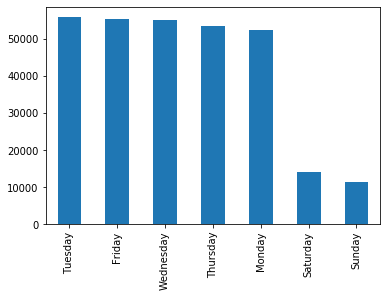

In [9]:
txDF['Start_TimeDayofweek'].value_counts().plot(kind='bar')

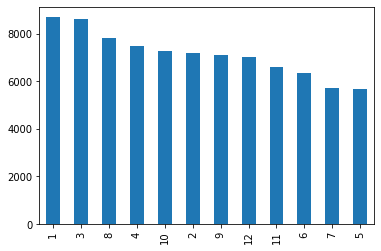

In [10]:
condition = txDF['Start_TimeYear'] == 2017

txDF[condition]['Start_TimeMonth'].value_counts().plot(kind='bar')


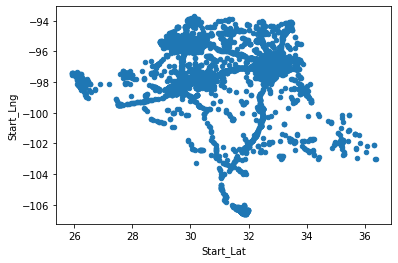

In [11]:
txDF.plot.scatter(x='Start_Lat',y='Start_Lng')

In [12]:
#create df for selected cities 
tx_metro_cities =  ['Austin', 'Round Rock', 'Cedar Park',
                 'San Marcos', 'Georgetown', 'Pflugerville',
                 'Hutto', 'Buda', 'Kyle', 'Leander',
                 'Dallas', 'Fort Worth', 'Arlington', 
                 'Plano','Garland', 'Irving', 'McKinney', 
                 'Frisco','Denton','Richardson', 'Allen','El Paso',
                 'Houston', 'The Woodlands', 'Sugar Land',
                 'Baytown', 'Conroe','San Antonio', 'New Braunfels', 
                 'Schertz', 'Seguin']
condition = txDF['City'].isin(tx_metro_cities)
tx_metro_cities_df = txDF[condition]
tx_metro_cities_df

print(f"Number of Columns : {len(tx_metro_cities_df.columns)}")
print(f"Number of Rows : {len(tx_metro_cities_df)}")


Number of Columns : 26
Number of Rows : 265605


In [13]:
def plot_map1(df,LatLong, city=None):
    accident_map = folium.Map(location=LatLong, 
#                           tiles = "Stamen Toner",
                           tiles = "OpenStreetMap",                              
                           zoom_start = 10)
    if city != None:
        data_heatmap = df[df["City"] == city]
    else:
        data_heatmap = df.copy()
    data_heatmap = data_heatmap[['Start_Lat','Start_Lng']]
    data_heatmap = [[row['Start_Lat'],row['Start_Lng']] for index, row in data_heatmap.iterrows()]
    HeatMap(data_heatmap, radius=10).add_to(accident_map)
    return accident_map

In [14]:
condition = tx_metro_cities_df['Start_TimeYear'] == 2017
plot_map1(tx_metro_cities_df[condition],[30.2672,-97.7431])


# Accidents in one Day



In [15]:
condition = (tx_metro_cities_df['Start_TimeYear'] == 2018) & (tx_metro_cities_df['City'] == 'Austin')
vc = tx_metro_cities_df[condition]['Start_TimeDayofyear'].value_counts().head()
vc

51     101
345     99
341     97
288     90
299     89
Name: Start_TimeDayofyear, dtype: int64

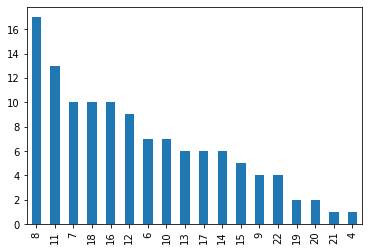

In [16]:
condition = (txDF['Start_TimeYear'] == 2017) & (txDF['City'] == 'Austin')  & (txDF['Start_TimeDayofyear']==340)
txDF[condition]['Start_TimeHour'].value_counts().plot(kind='bar')

In [17]:
timeBins = [0,5,9,13,16,19,24]
groupNames = ['<5','6-9','10-13','14-16','16-19','19-24']
txDF['HourGroup']=pd.cut(txDF['Start_TimeHour'],timeBins, labels=groupNames)
txDF['HourGroup'].head()

261007    14-16
261008    14-16
261009    14-16
261010    14-16
261011    14-16
Name: HourGroup, dtype: category
Categories (6, object): [<5 < 6-9 < 10-13 < 14-16 < 16-19 < 19-24]

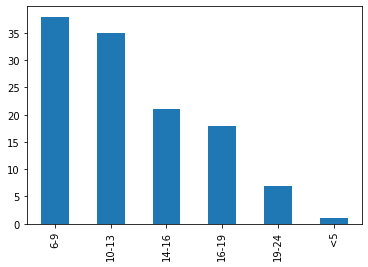

In [18]:
condition = (txDF['Start_TimeYear'] == 2017) & (txDF['City'] == 'Austin')  & (txDF['Start_TimeDayofyear']==340)
txDF[condition]['HourGroup'].value_counts().plot(kind='bar')

In [19]:
condition = (txDF['Start_TimeYear'] == 2017) & (txDF['City'] == 'Austin')  & (txDF['Start_TimeDayofyear']==340)
onedf=txDF[condition].sort_values('Start_TimeHour')
import dtale
d= dtale.show(onedf,ignore_duplicate=True)
d